In [1]:
#! /usr/bin/env python
'''
    code for gaussian mixture solver
    based on Kalai STOC'10 paper
    Efficiently learning mixtures of two gaussians
'''
from __future__ import division
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import mixture
import time
%matplotlib inline 

In [115]:
class TwoGaussian(object):
    def __init__(self, SAF):
        self.mu = np.mean(SAF)
        sample = SAF - self.mu
        self.M1 = np.mean(sample)
        self.M2 = np.mean(sample**2)
        self.M3 = np.mean(sample**3)
        self.M4 = np.mean(sample**4)
        self.M5 = np.mean(sample**5)
        self.M6 = np.mean(sample**6)
        self.x3 = self.M3
        self.x4 = self.M4 - 3* self.M2**2
        self.x5 = self.M5 - 10 * self.M3 * self.M2
        self.x6 = self.M6 - 15 * self.M4 * self.M2 + 30 * self.M2**3
        #self.alpha
        #self.gamma
        #self.beta
        
    def recoverAlphaFromMoment(self, eps):
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        coeff = [2, 0, X4, -X3**2]
        ymax = np.max(np.roots(coeff))
        kai = 1 + np.sqrt(np.abs(X4))/ymax
        #remove 18th degree polynomial for reference in later session
        
        #only keep cofficients of the first derivative of r(y)
        coeff= self.rprime(X3, X4, X5, X6)
        R = np.roots(coeff)
        #real_valued = R.real[abs(R.imag)<1e-5] # where I chose 1-e5 as a threshold
        #print R
        #print real_valued
        candidates = np.append(R, (1+eps/kai)*ymax)
        alphaOPT = float('-inf')
        thred1 = (1+eps/kai)*ymax
        thred2 = (eps**2)*(kai**10)
        small_candidates = candidates[(candidates <= thred1)*(candidates >= 0)]
        res = [x for x in small_candidates if self.ry(x) <= thred2*x**18]
        assert len(res) > 0, 'no valid solution for alpha'
        return np.max(res)
    
    def recoverFromMoments(self, eps):
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        #mu = self.M1
        sigma2 = self.M2 - self.M1**2
        alpha = self.recoverAlphaFromMoment(eps)
        gamma = self.gammafunc(alpha)
        beta = self.betafunc(alpha, gamma)
        mu1, mu2 = self.mufunc(alpha, beta)
        w1, w2 = self.weightfunc(mu1, mu2)
        sigma2_1 = sigma2 - (w1*mu1**2 + w2*mu2**2 - mu1*gamma)
        sigma2_2 = sigma2_1 + (mu2 - mu1)*gamma
        print 'alpha = {}, beta = {}, gamma = {}'.format(alpha, beta, gamma)
        #return [[w1,w2], [ mu1+self.mu,mu2+self.mu], [np.sqrt(sigma2_1), np.sqrt(sigma2_2)]]
        return [[w1,w2], [ mu1-self.mu,mu2-self.mu], [np.sqrt(sigma2_1), np.sqrt(sigma2_2)]]
        #res = [[w1,w2], [ mu1+mu,mu2+mu], [np.sqrt(sigma2_1), np.sqrt(sigma2_2)]]
        #return res
    
    def ry(self, y):
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        ry = 80*X3**12 - 640*X3**10*X4*y + 1984*X3**10*y**3 + \
        464*X3**9*X5*y**2 + 1720*X3**8*X4**2*y**2 - 10880*X3**8*X4*y**4 - \
        32*X3**8*X6*y**3 + 11872*X3**8*y**6 - 2488*X3**7*X4*X5*y**3 + \
        6096*X3**7*X5*y**5 - 1640*X3**6*X4**3*y**3 + 17920*X3**6*X4**2*y**5 + \
        152*X3**6*X4*X6*y**4 - 33888*X3**6*X4*y**7 + 772*X3**6*X5**2*y**4 - \
        432*X3**6*X6*y**6 - 6144*X3**6*y**9 + 3796*X3**5*X4**2*X5*y**4 - \
        17712*X3**5*X4*X5*y**6 - 80*X3**5*X5*X6*y**5 + 3088*X3**5*X5*y**8 + \
        130*X3**4*X4**4*y**4 - 9320*X3**4*X4**3*y**6 - 200*X3**4*X4**2*X6*y**5 + \
        31184*X3**4*X4**2*y**8 - 2252*X3**4*X4*X5**2*y**5 + 848*X3**4*X4*X6*y**7 + \
        16480*X3**4*X4*y**10 + 2264*X3**4*X5**2*y**7 + 16*X3**4*X6**2*y**6 + 512*X3**4*X6*y**9 + \
        3872*X3**4*y**12 - 1322*X3**3*X4**3*X5*y**5 + 14500*X3**3*X4**2*X5*y**7 + \
        116*X3**3*X4*X5*X6*y**6 - 3544*X3**3*X4*X5*y**9 + 288*X3**3*X5**3*y**6 + \
        56*X3**3*X5*X6*y**8 + 112*X3**3*X5*y**11 + 300*X3**2*X4**5*y**5 - 400*X3**2*X4**4*y**7 + \
        102*X3**2*X4**3*X6*y**6 - 10144*X3**2*X4**3*y**9 + 1597*X3**2*X4**2*X5**2*y**6 - \
        556*X3**2*X4**2*X6*y**8 - 14080*X3**2*X4**2*y**11 - 3476*X3**2*X4*X5**2*y**8 - \
        24*X3**2*X4*X6**2*y**7 - 728*X3**2*X4*X6*y**10 - 6208*X3**2*X4*y**13 + 436*X3**2*X5**2*y**10 - \
        16*X3**2*X6**2*y**9 - 208*X3**2*X6*y**12 - 768*X3**2*y**15 - 606*X3*X4**4*X5*y**6 - \
        2024*X3*X4**3*X5*y**8 - 42*X3*X4**2*X5*X6*y**7 - 1056*X3*X4**2*X5*y**10 - \
        432*X3*X4*X5**3*y**7 - 40*X3*X4*X5*X6*y**9 + 544*X3*X4*X5*y**12 + 288*X3*X5**3*y**9 - \
        8*X3*X5*X6*y**11 + 352*X3*X5*y**14 + 90*X4**6*y**6 + 408*X4**5*y**8 - 18*X4**4*X6*y**7 + \
        1720*X4**4*y**10 + 108*X4**3*X5**2*y**7 + 120*X4**3*X6*y**9 + 3008*X4**3*y**12 + \
        360*X4**2*X5**2*y**9 + 9*X4**2*X6**2*y**8 + 256*X4**2*X6*y**11 + 2400*X4**2*y**14 + \
        336*X4*X5**2*y**11 + 12*X4*X6**2*y**10 + 160*X4*X6*y**13 + 896*X4*y**16 + 36*X5**4*y**8 + \
        96*X5**2*y**13 + 4*X6**2*y**12 + 32*X6*y**15 + 128*y**18
        return ry
    
    def rprime(self, X3, X4, X5, X6):
        res = [2304,\
 0,\
 14336*X4,\
 -11520*X3**2 + 480*X6,\
 4928*X3*X5 + 33600*X4**2,\
 -80704*X3**2*X4 + 2080*X4*X6 + 1248*X5**2,\
 46464*X3**4 - 2496*X3**2*X6 + 6528*X3*X4*X5 + 36096*X4**3 + 48*X6**2,\
 1232*X3**3*X5 - 154880*X3**2*X4**2 - 88*X3*X5*X6 + 2816*X4**2*X6 + 3696*X4*X5**2,\
 164800*X3**4*X4 - 7280*X3**2*X4*X6 + 4360*X3**2*X5**2 - 10560*X3*X4**2*X5 + 17200*X4**4 + 120*X4*X6**2,\
 -55296*X3**6 + 4608*X3**4*X6 - 31896*X3**3*X4*X5 - 91296*X3**2*X4**3 - 144*X3**2*X6**2 - 360*X3*X4*X5*X6 + 2592*X3*X5**3 + 1080*X4**3*X6 + 3240*X4**2*X5**2,\
 24704*X3**5*X5 + 249472*X3**4*X4**2 + 448*X3**3*X5*X6 - 4448*X3**2*X4**2*X6 - 27808*X3**2*X4*X5**2 - 16192*X3*X4**3*X5 + 3264*X4**5 + 72*X4**2*X6**2 + 288*X5**4,\
 -237216*X3**6*X4 + 5936*X3**4*X4*X6 + 15848*X3**4*X5**2 + 101500*X3**3*X4**2*X5 - 2800*X3**2*X4**4 - 168*X3**2*X4*X6**2 - 294*X3*X4**2*X5*X6 - 3024*X3*X4*X5**3 - 126*X4**4*X6 + 756*X4**3*X5**2,\
 71232*X3**8 - 2592*X3**6*X6 - 106272*X3**5*X4*X5 - 55920*X3**4*X4**3 + 96*X3**4*X6**2 + 696*X3**3*X4*X5*X6 + 1728*X3**3*X5**3 + 612*X3**2*X4**3*X6 + 9582*X3**2*X4**2*X5**2 - 3636*X3*X4**4*X5 + 540*X4**6,\
 30480*X3**7*X5 + 89600*X3**6*X4**2 - 400*X3**5*X5*X6 - 1000*X3**4*X4**2*X6 - 11260*X3**4*X4*X5**2 - 6610*X3**3*X4**3*X5 + 1500*X3**2*X4**5,\
 -43520*X3**8*X4 + 608*X3**6*X4*X6 + 3088*X3**6*X5**2 + 15184*X3**5*X4**2*X5 + 520*X3**4*X4**4,\
 5952*X3**10 - 96*X3**8*X6 - 7464*X3**7*X4*X5 - 4920*X3**6*X4**3,\
 928*X3**9*X5 + 3440*X3**8*X4**2,\
 -640*X3**10*X4]
        return res
    
    def gammafunc(self, a):
        assert a!= 0,'alpha can not be zero!'
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        numerator = a**2 * X5 + 2*X3**3 + 2*a**3*X3 - 3*X3*X4*a
        denominator = 4*X3**2 - 2 * a**3 - 3*X4*a
        return numerator/(denominator*a)
    def betafunc(self, a, g):
        X3 = self.x3
        return (X3 - 3*a*g)/a
    def mufunc(self, a, b):
        res = [(-b - np.sqrt(b**2 + 4*a))*0.5, (-b + np.sqrt(b**2 + 4*a))*0.5]
        return res
    def weightfunc(self, m1, m2):
        assert m2 != m1
        #m1 = m1 + self.mu
        #m2 = m2 + self.mu
        print [m1, m2]
        res = [m2/(m2 - m1), -m1/(m2-m1)]
        print res
        return res

In [116]:
class Test(object):
    def __init__(self, param, n_samples, seed = 0):
            self.w1 = param[0]
            self.w2 = param[1]
            self.mu1 = param[2]
            self.mu2 = param[3]
            self.sigma1 = param[4]
            self.sigma2 = param[5]
            self.n_samples = n_samples
            self.sample2d, self.sample1d  = self.sample()
            
    def sample(self, seed = 0):
        gmix = mixture.GaussianMixture(n_components=2, covariance_type='full')
        gmix.fit(np.random.rand(2,1))  # Now it thinks it is trained
        gmix.weights_ = np.array([self.w1, self.w2]) # mixture weights (n_components,) 
        gmix.means_ = np.array([[self.mu1], [self.mu2]])         # mixture means (n_components, 2) 
        gmix.covariances_ = np.array([[[self.sigma1**2]], [[self.sigma2**2]]]) # mixture cov (n_components, 2, 2)
        sample, _ = gmix.sample(self.n_samples)
        return (sample, sample.flatten())

    def unitest(self, eps, isplot = True):
        # fit a Gaussian Mixture Model with two components
        start = time.time()
        clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
        clf.fit(self.sample2d)
        end = time.time()
        t1 = (end - start)

        start = time.time()
        test = TwoGaussian(self.sample1d)
        res = test.recoverFromMoments(0.1)
        end = time.time()
        t2 = (end - start)
        print "Skelearn GMM cost time is: {} sec. \n".format(t1)
        print "Moment method GMM cost time is: {} sec. \n".format(t2)
        param1 = self.parseGMM(clf)
        param2 = self.parseTwoGmm(res)
        if isplot:
            self.plot(param1.flatten(), param2.flatten())
        return (param1, param2)
    
    def parseGMM(self, model):
        return np.round([model.weights_.flatten(), model.means_.flatten(), np.sqrt(model.covariances_.flatten())],4)
    
    def parseTwoGmm(self, model):
        model = np.array(model)
        return np.round(model.real,4)
    def generateMixture(self, bins, param):
        assert len(param) == 6
        return param[0]*norm.pdf(bins, loc=param[2], scale=param[4])\
        +param[1]*norm.pdf(bins, loc=param[3], scale=param[5])
        
    def plot(self, param1, param2):
        n, bins, patches =plt.hist(self.sample1d, 50, normed=1, facecolor='green', alpha=0.75)
        y1 = self.generateMixture(bins, param1)
        plot1 = plt.plot(bins, y1, 'r--', linewidth=1, color = 'red')
        y2 = self.generateMixture(bins, param2)
        plot2 = plt.plot(bins, y2, 'r--', linewidth=1, color = 'blue')


[(-2.0399095854096929-0j), (2.0389984190819384+0j)]
[(0.49988830756580543+0j), (0.50011169243419451+0j)]
alpha = (4.15937241972+0j), beta = (0.000911166327755+0j), gamma = (-0.000390847173126+0j)
Skelearn GMM cost time is: 0.841949939728 sec. 

Moment method GMM cost time is: 0.12584400177 sec. 



(array([[ 0.5002,  0.4998],
        [-1.9988,  1.9988],
        [ 1.0002,  0.9989]]), array([[ 0.4999,  0.5001],
        [-2.0391,  2.0399],
        [ 0.9142,  0.9133]]))

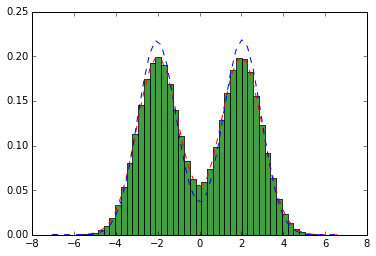

In [128]:
unitest = Test(param = [0.5, 0.5, -2, 2, 1, 1],n_samples=1000000)
unitest.unitest(1)

In [50]:
haha = np.array([[ 0.8687,  0.1313],
        [-2.0426,  1.4186],
        [ 0.8825,  1.977 ]])
x, y, z = haha
print x
print y
print z
print haha.flatten()

[ 0.8687  0.1313]
[-2.0426  1.4186]
[ 0.8825  1.977 ]
[ 0.8687  0.1313 -2.0426  1.4186  0.8825  1.977 ]


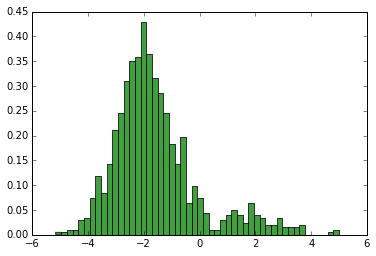

In [45]:
unitest.plot()

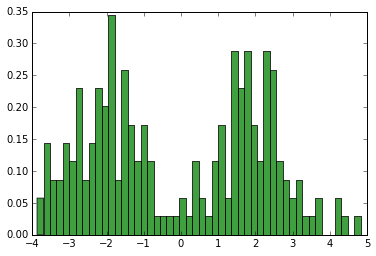

In [59]:
x = np.random.normal(-2, 1, 100)
y = np.append(x, np.random.normal(2, 1, 100))
n, bins, patches =plt.hist(y, 50, normed=1, facecolor='green', alpha=0.75)
#pred = res.x[0]*norm.pdf(bins, loc=res.x[1], scale=res.x[2])\
#+(1-res.x[0])*norm.pdf(bins, loc=res.x[3], scale=np.abs(res.x[4]))
#l = plt.plot(bins, pred, 'r--', linewidth=1)
#plt.show()

In [ ]:
y = res.x[0]*norm.pdf(bins, loc=res.x[1], scale=res.x[2])\
+(1-res.x[0])*norm.pdf(bins, loc=res.x[3], scale=np.abs(res.x[4]))
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()